### Bayesian Inference (Bonus)

##### Particle Marginal Metropolis-Hastings (PMMH)

Using the bootstrap PF and RobPF respectively as likelihood estimator, the target is the full posterior distrib of the parameters, assuming weak priors on the 4 parameters (more robust to local optima)

$p_{Gaussian}​(θ∣y)$ vs $p_{Robust}​(θ∣y)$

PMMH is supposed to explore posterior and mix well  with RPF because its likelihood is smooth and there is no particle collapse.


We compare PMMH inference under a Gaussian observation model (bootstrap PF) and a robust observation model, highlighting the impact of likelihood misspecification on parameter inference and uncertainty

We first validate the inference procedure on simulated data with known ground truth (clean vs contaminated).

We then apply the method to real financial volume data to illustrate the practical impact of robust likelihood modeling


##### SMC2 (Sequential Monte Carlo Squared)
Avoids getting stuck in local modes early because it keeps many parameters and for each runs a particle filter on the states, it gives time evolving posterior but is more expensive 

PMMH is the canonical bayesian extension of particle filters , in this case, due to the substantially higher comp cost of SMC2 and limited additional insight in an offline setting, we will extend the robust PF to full bayesian inference using only PMMH, which leverages the smooth robustified likelihood to obtain well-mixing posterior samples.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

# Import from the shared module (smc_models.py)
from script_pmmh import (
    bootstrap_pf_particles,
    robust_pf_particles,
    robust_gaussian_density,
    TradingVolumeModel,
    RobustBootstrap
)

In [ ]:
# GENERATE SIMULATED DATA
np.random.seed(42)

# Ground truth parameters
theta_true = np.array([0.3, 0.015, 0.995, 0.015])  # sigma_y, a, b, sigma_x
T = 2000  # Time series length

# Simulate data from the true model
model_true = TradingVolumeModel(sigma_y=theta_true[0], a=theta_true[1], 
                                 b=theta_true[2], sigma_x=theta_true[3])
x_true, y_sim = model_true.simulate(T)
y_sim = np.array(y_sim).flatten()

print(f"Simulated data length: {len(y_sim)}")
print(f"True parameters: sigma_y={theta_true[0]:.3f}, a={theta_true[1]:.3f}, "
      f"b={theta_true[2]:.3f}, sigma_x={theta_true[3]:.3f}")
print(f"y_sim range: [{y_sim.min():.3f}, {y_sim.max():.3f}]")


Simulated data length: 2000
True parameters: sigma_y=0.300, a=0.015, b=0.995, sigma_x=0.015
y_sim range: [-0.609, 5.151]


In [ ]:
# PRIOR AND PROPOSAL 
def log_prior(theta):
    sigma_y, a, b, sigma_x = theta
    if not (0.01 < sigma_y < 2.0):
        return -np.inf
    if not (-0.1 < a < 0.1):
        return -np.inf
    if not (0.9 < b < 0.9999):
        return -np.inf
    if not (0.001 < sigma_x < 0.1):
        return -np.inf
    return 0.0

Sigma_prop = np.diag([
    0.003**2,     # sigma_y
    0.0003**2,    # a
    0.00003**2,   # b
    0.0003**2     # sigma_x
])

def propose(theta, Sigma):
    return np.random.multivariate_normal(theta, Sigma)


In [39]:
# PMMH WITH BOOTSTRAP PF (Gaussian)
def PMMH_bootstrap(y, theta_init, N_particles=500, n_iter=3000, burn_in=1000, Sigma_prop=Sigma_prop):
    """PMMH using bootstrap (Gaussian) particle filter."""
    theta_curr = np.array(theta_init)
    _, loglik_curr, _ = bootstrap_pf_particles(y, theta_curr, N=N_particles)
    logpost_curr = loglik_curr + log_prior(theta_curr)
    
    chain = np.zeros((n_iter, len(theta_curr)))
    accept = 0
    
    for m in range(n_iter):
        if (m + 1) % 200 == 0:
            print(f"Bootstrap PMMH: {m+1}/{n_iter} (acc: {accept/(m+1):.2%})")
        
        theta_prop = propose(theta_curr, Sigma_prop)
        lp_prop = log_prior(theta_prop)
        if lp_prop == -np.inf:
            chain[m] = theta_curr
            continue
        
        _, loglik_prop, _ = bootstrap_pf_particles(y, theta_prop, N=N_particles)
        logpost_prop = loglik_prop + lp_prop
        
        if np.log(np.random.rand()) < logpost_prop - logpost_curr:
            theta_curr = theta_prop
            loglik_curr = loglik_prop
            logpost_curr = logpost_prop
            accept += 1
        
        chain[m] = theta_curr
    
    return chain[burn_in:], accept / n_iter

# PMMH WITH ROBUST PF 
def PMMH_robust(y, theta_init, N_particles=500, n_iter=3000, burn_in=1000, 
                Sigma_prop=Sigma_prop, c=5.14):
    """PMMH using robust particle filter."""
    theta_curr = np.array(theta_init)
    _, loglik_curr, _ = robust_pf_particles(y, theta_curr, N=N_particles, c=c)
    logpost_curr = loglik_curr + log_prior(theta_curr)
    
    chain = np.zeros((n_iter, len(theta_curr)))
    accept = 0
    
    for m in range(n_iter):
        if (m + 1) % 200 == 0:
            print(f"Robust PMMH: {m+1}/{n_iter} (acc: {accept/(m+1):.2%})")
        
        theta_prop = propose(theta_curr, Sigma_prop)
        lp_prop = log_prior(theta_prop)
        if lp_prop == -np.inf:
            chain[m] = theta_curr
            continue
        
        _, loglik_prop, _ = robust_pf_particles(y, theta_prop, N=N_particles, c=c)
        logpost_prop = loglik_prop + lp_prop
        
        if np.log(np.random.rand()) < logpost_prop - logpost_curr:
            theta_curr = theta_prop
            loglik_curr = loglik_prop
            logpost_curr = logpost_prop
            accept += 1
        
        chain[m] = theta_curr
    
    return chain[burn_in:], accept / n_iter


In [45]:
# VISUALIZATION 
def plot_posterior_marginals(chains_dict, theta_true=None, param_names=['sigma_y', 'a', 'b', 'sigma_x']):
    """Plot posterior marginal histograms with optional ground truth."""
    n_params = len(param_names)
    fig, axes = plt.subplots(1, n_params, figsize=(16, 3))
    if n_params == 1:
        axes = [axes]
    
    for i, (ax, name) in enumerate(zip(axes, param_names)):
        for method, chain in chains_dict.items():
            ax.hist(chain[:, i], bins=30, alpha=0.6, label=method, density=True)
        if theta_true is not None:
            ax.axvline(theta_true[i], color='red', linestyle='--', linewidth=2, label='True')
        ax.set_xlabel(name)
        ax.set_ylabel('Density')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

def plot_joint_posteriors(chains_dict, theta_true=None, param_names=['sigma_y', 'a', 'b', 'sigma_x']):
    """Plot joint posterior scatter plots with optional ground truth."""
    n_params = len(param_names)
    fig, axes = plt.subplots(n_params, n_params, figsize=(12, 12))
    
    for i in range(n_params):
        for j in range(n_params):
            ax = axes[i, j]
            if i == j:
                # Diagonal: marginal histograms
                for method, chain in chains_dict.items():
                    ax.hist(chain[:, i], bins=20, alpha=0.5, label=method, density=True)
                if theta_true is not None:
                    ax.axvline(theta_true[i], color='red', linestyle='--', linewidth=2)
                ax.set_xlabel(param_names[i])
            else:
                # Off-diagonal: scatter plots
                for method, chain in chains_dict.items():
                    ax.scatter(chain[:, j], chain[:, i], alpha=0.3, s=10, label=method)
                if theta_true is not None:
                    ax.scatter(theta_true[j], theta_true[i], color='red', s=100, marker='x', 
                              linewidths=3, label='True', zorder=10)
                ax.set_xlabel(param_names[j])
                ax.set_ylabel(param_names[i])
            if i == 0 and j == n_params - 1:
                ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

def plot_traces(chains_dict, param_names=['sigma_y', 'a', 'b', 'sigma_x']):
    """Plot trace plots for MCMC chains."""
    n_params = len(param_names)
    fig, axes = plt.subplots(n_params, 1, figsize=(12, 10))
    if n_params == 1:
        axes = [axes]
    
    for i, (ax, name) in enumerate(zip(axes, param_names)):
        for method, chain in chains_dict.items():
            ax.plot(chain[:, i], alpha=0.7, label=method, linewidth=0.5)
        ax.set_ylabel(name)
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    axes[-1].set_xlabel('Iteration')
    plt.tight_layout()
    return fig

def plot_posterior_predictive(y_obs, chains_dict, param_names=['sigma_y', 'a', 'b', 'sigma_x'], 
                              n_samples=50):
    """Posterior predictive checks: simulate from posterior samples."""
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    
    # Sample parameters from chains
    for method, chain in chains_dict.items():
        n_samples_chain = min(n_samples, len(chain))
        idx = np.random.choice(len(chain), n_samples_chain, replace=False)
        theta_samples = chain[idx]
        
        y_pred_list = []
        for theta in theta_samples:
            model = TradingVolumeModel(sigma_y=theta[0], a=theta[1], b=theta[2], sigma_x=theta[3])
            _, y_pred = model.simulate(len(y_obs))
            y_pred_list.append(np.array(y_pred).flatten())
        
        y_pred_array = np.array(y_pred_list)
        y_pred_mean = y_pred_array.mean(axis=0)
        y_pred_std = y_pred_array.std(axis=0)
        
        axes[0].plot(y_pred_mean, alpha=0.6, label=f'{method} (mean)', linewidth=2)
        axes[1].fill_between(range(len(y_pred_mean)), 
                            y_pred_mean - 2*y_pred_std, 
                            y_pred_mean + 2*y_pred_std, 
                            alpha=0.2, label=f'{method} (95% CI)')
    
    axes[0].plot(y_obs, 'k-', linewidth=1, label='Observed', alpha=0.7)
    axes[1].plot(y_obs, 'k-', linewidth=1, label='Observed', alpha=0.7)
    
    axes[0].set_ylabel('Mean prediction')
    axes[0].set_title('Posterior Predictive: Mean')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    axes[1].set_ylabel('Value')
    axes[1].set_xlabel('Time')
    axes[1].set_title('Posterior Predictive: 95% Credible Intervals')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig


In [ ]:
# RUN PMMH 
theta_init = [0.35, 0.012, 0.992, 0.018]  # Close to true values
param_names = ['sigma_y', 'a', 'b', 'sigma_x']

# Run Bootstrap PMMH
print("="*60)
print("Running Bootstrap PMMH (Gaussian observation model)...")
print("="*60)
chain_bootstrap, acc_bootstrap = PMMH_bootstrap(
    y_sim, theta_init, 
    N_particles=1000, 
    n_iter=5000, 
    burn_in=1000
)

# Run Robust PMMH
print("\n" + "="*60)
print("Running Robust PMMH (Robust observation model)...")
print("="*60)
chain_robust, acc_robust = PMMH_robust(
    y_sim, theta_init, 
    N_particles=1000, 
    n_iter=5000, 
    burn_in=1000
)

# Store chains
chains_dict = {
    'Bootstrap PF': chain_bootstrap,
    'Robust PF': chain_robust
}

print("\n" + "="*60)
print("Results Summary")
print("="*60)
print(f"Bootstrap PF acceptance rate: {acc_bootstrap:.2%}")
print(f"Robust PF acceptance rate: {acc_robust:.2%}")
print(f"\nBootstrap PF posterior means: {chain_bootstrap.mean(axis=0)}")
print(f"Robust PF posterior means: {chain_robust.mean(axis=0)}")
print(f"True parameters: {theta_true}")
print("="*60)


Running Bootstrap PMMH (Gaussian observation model)...
Bootstrap PMMH: 200/5000 (acc: 43.50%)
Bootstrap PMMH: 400/5000 (acc: 44.75%)
Bootstrap PMMH: 600/5000 (acc: 44.17%)
Bootstrap PMMH: 800/5000 (acc: 44.38%)
Bootstrap PMMH: 1000/5000 (acc: 46.10%)
Bootstrap PMMH: 1200/5000 (acc: 45.42%)
Bootstrap PMMH: 1400/5000 (acc: 45.50%)
Bootstrap PMMH: 1600/5000 (acc: 46.31%)
Bootstrap PMMH: 1800/5000 (acc: 46.89%)
Bootstrap PMMH: 2000/5000 (acc: 45.95%)
Bootstrap PMMH: 2200/5000 (acc: 45.23%)
Bootstrap PMMH: 2400/5000 (acc: 45.38%)
Bootstrap PMMH: 2600/5000 (acc: 45.00%)
Bootstrap PMMH: 2800/5000 (acc: 44.54%)
Bootstrap PMMH: 3000/5000 (acc: 45.17%)
Bootstrap PMMH: 3200/5000 (acc: 45.28%)
Bootstrap PMMH: 3400/5000 (acc: 45.06%)
Bootstrap PMMH: 3600/5000 (acc: 45.03%)
Bootstrap PMMH: 3800/5000 (acc: 44.84%)
Bootstrap PMMH: 4000/5000 (acc: 44.12%)
Bootstrap PMMH: 4200/5000 (acc: 43.93%)
Bootstrap PMMH: 4400/5000 (acc: 43.95%)
Bootstrap PMMH: 4600/5000 (acc: 43.76%)
Bootstrap PMMH: 4800/5000 (ac

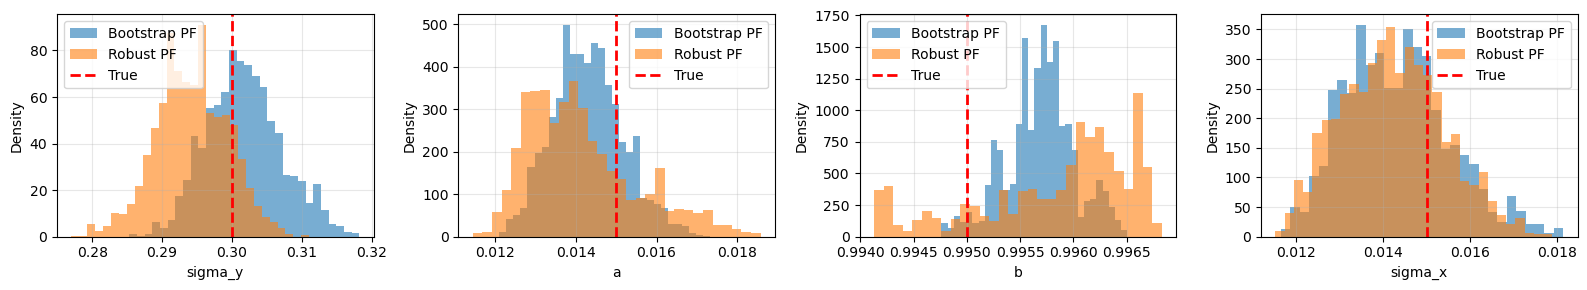

In [ ]:
# POSTERIOR MARGINAL HISTOGRAMS
fig = plot_posterior_marginals(chains_dict, theta_true, param_names)
plt.show()


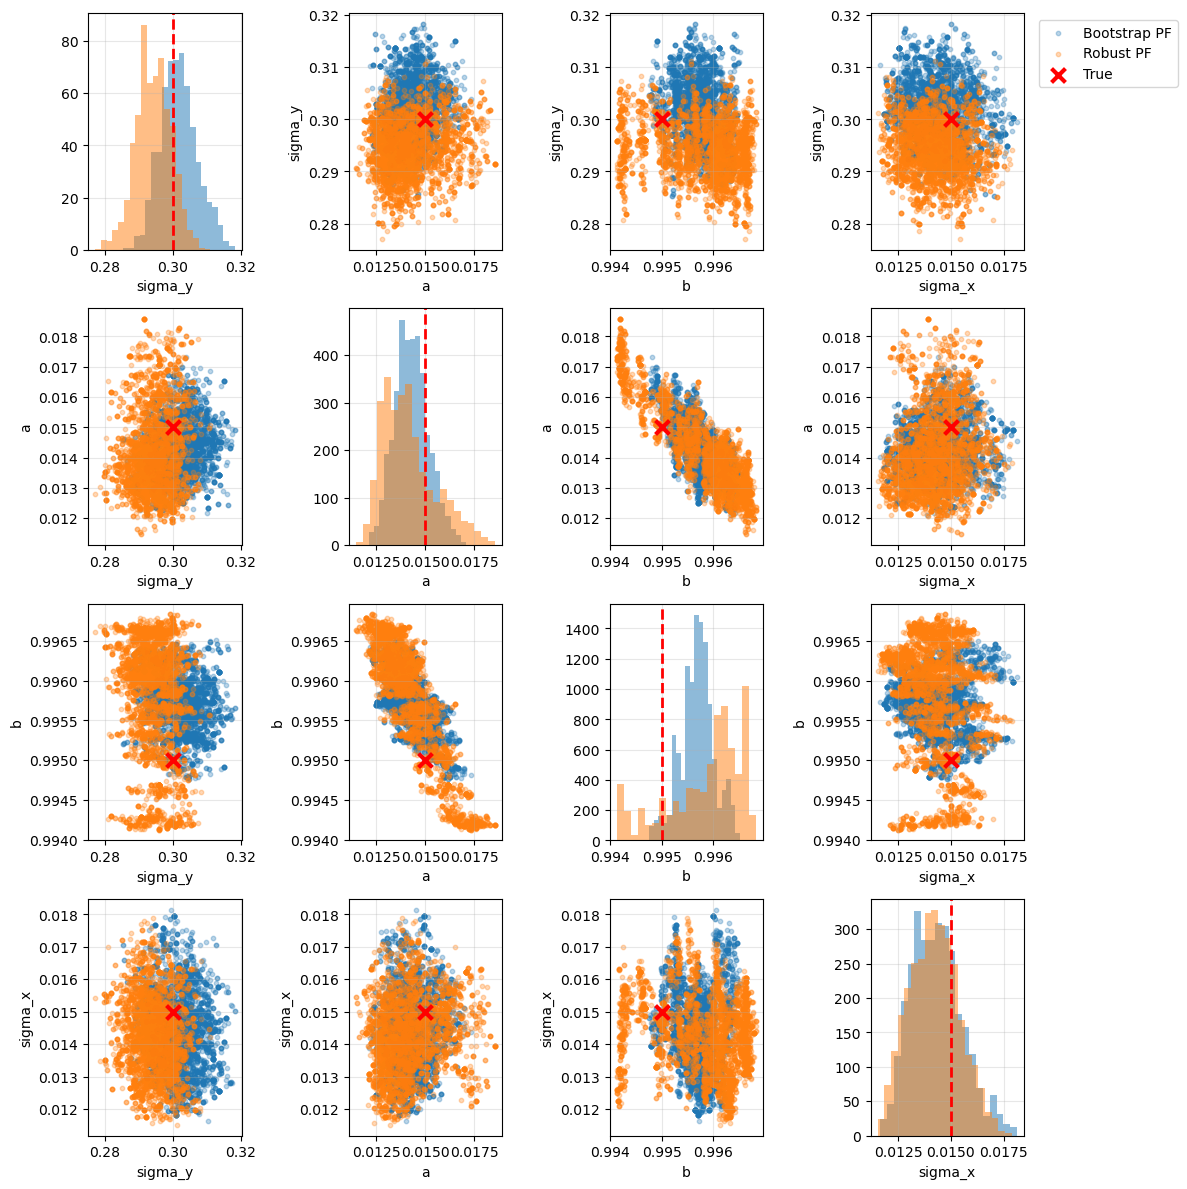

In [ ]:
# JOINT POSTERIOR SCATTER PLOTS 
fig = plot_joint_posteriors(chains_dict, theta_true, param_names)
plt.show()


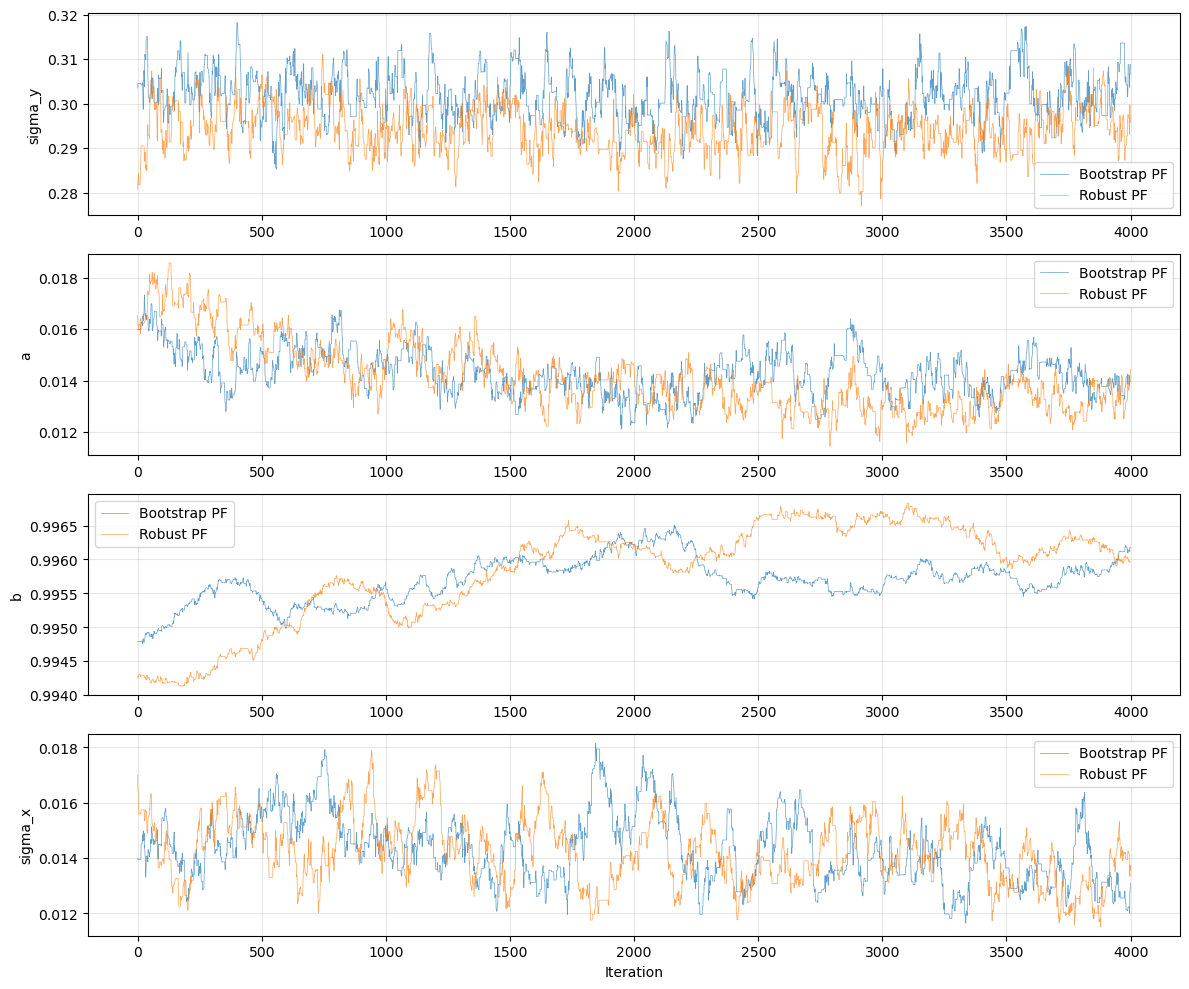

In [ ]:
# TRACE PLOTS 
fig = plot_traces(chains_dict, param_names)
plt.show()


On clean simulated data generated from the Gaussian model, both the standard bootstrap particle filter and the robust particle filter give very similar results. Since there are no outliers, the Gaussian likelihood is correctly specified and the robust mechanism is essentially inactive, so both methods recover the true parameters with comparable uncertainty. Robust methods do nothing when there is nothing to be robust against.

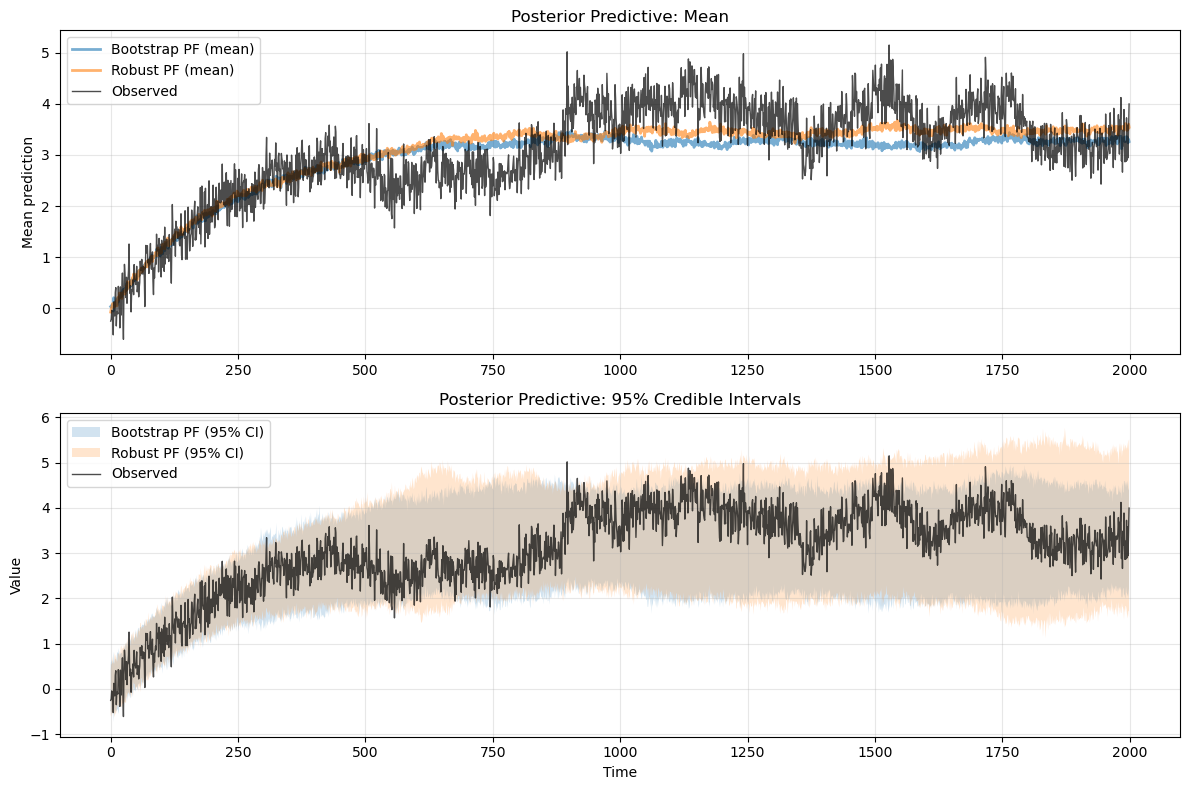

In [ ]:
# POSTERIOR PREDICTIVE CHECKS
fig = plot_posterior_predictive(y_sim, chains_dict, param_names, n_samples=50)
plt.show()


On clean simulated data, the posterior predictive means and credible intervals from the bootstrap and robust particle filters are nearly identical, confirming that robustness does not distort inference when the model is correctly specified.

In [ ]:
# COMPARISON: POSTERIOR STATISTICS 
print("Posterior Statistics Comparison")
print("="*80)

for i, name in enumerate(param_names):
    print(f"\n{name} (True: {theta_true[i]:.4f}):")
    print(f"  Bootstrap PF: Mean={chain_bootstrap[:, i].mean():.4f}, "
          f"Std={chain_bootstrap[:, i].std():.4f}, "
          f"95% CI=[{np.percentile(chain_bootstrap[:, i], 2.5):.4f}, "
          f"{np.percentile(chain_bootstrap[:, i], 97.5):.4f}]")
    print(f"  Robust PF:    Mean={chain_robust[:, i].mean():.4f}, "
          f"Std={chain_robust[:, i].std():.4f}, "
          f"95% CI=[{np.percentile(chain_robust[:, i], 2.5):.4f}, "
          f"{np.percentile(chain_robust[:, i], 97.5):.4f}]")
    


Posterior Statistics Comparison
sigma_y (True: 0.3000):
  Bootstrap PF: Mean=0.3018, Std=0.0054, 95% CI=[0.2923, 0.3132]
  Robust PF:    Mean=0.2942, Std=0.0051, 95% CI=[0.2838, 0.3039]

a (True: 0.0150):
  Bootstrap PF: Mean=0.0143, Std=0.0009, 95% CI=[0.0127, 0.0161]
  Robust PF:    Mean=0.0142, Std=0.0014, 95% CI=[0.0122, 0.0174]

b (True: 0.9950):
  Bootstrap PF: Mean=0.9957, Std=0.0003, 95% CI=[0.9950, 0.9963]
  Robust PF:    Mean=0.9958, Std=0.0007, 95% CI=[0.9942, 0.9967]

sigma_x (True: 0.0150):
  Bootstrap PF: Mean=0.0143, Std=0.0012, 95% CI=[0.0123, 0.0170]
  Robust PF:    Mean=0.0142, Std=0.0012, 95% CI=[0.0120, 0.0166]



## Noisy simulated data

In [ ]:
# CONTAMINATED SIMULATED DATA 
np.random.seed(42) 

# Contamination function
def contaminate_data(y_clean, x_clean, sigma_y, p_contam=0.05, eta=14):
    """Contaminate data by adding outliers with probability p_contam."""
    y_cont = y_clean.copy()
    T = len(y_clean)
    n_contaminated = 0
    for t in range(T):
        if np.random.rand() < p_contam:
            mu_t = x_clean[t] - (sigma_y**2) / 2
            radius = np.abs(y_clean[t] - mu_t)
            u_t = np.random.uniform(-radius, radius)
            y_cont[t] = y_clean[t] + eta * u_t
            n_contaminated += 1
    return y_cont, n_contaminated

# Contaminate the simulated data
p_contam = 0.05
eta = 14
y_sim_contam, n_contam = contaminate_data(y_sim, x_true, theta_true[0], p_contam=p_contam, eta=eta)

print(f"Contaminated {n_contam} out of {len(y_sim)} observations ({100*n_contam/len(y_sim):.1f}%)")
print(f"Contamination parameters: p_contam={p_contam}, eta={eta}")
print(f"y_sim_contam range: [{y_sim_contam.min():.3f}, {y_sim_contam.max():.3f}]")
print(f"Original y_sim range: [{y_sim.min():.3f}, {y_sim.max():.3f}]")

# RUN PMMH ON CONTAMINATED DATA 
theta_init_contam = [0.35, 0.012, 0.992, 0.018]  # Same initialization

# Run Bootstrap PMMH on contaminated data
print("\n" + "="*60)
print("Running Bootstrap PMMH on CONTAMINATED data (Gaussian observation model)...")
print("="*60)
chain_bootstrap_contam, acc_bootstrap_contam = PMMH_bootstrap(
    y_sim_contam, theta_init_contam, 
    N_particles=1000,
    n_iter=5000, 
    burn_in=1000
)

# Run Robust PMMH on contaminated data
print("\n" + "="*60)
print("Running Robust PMMH on CONTAMINATED data (Robust observation model)...")
print("="*60)
chain_robust_contam, acc_robust_contam = PMMH_robust(
    y_sim_contam, theta_init_contam, 
    N_particles=1000,
    n_iter=5000, 
    burn_in=1000
)

# Store chains
chains_dict_contam = {
    'Bootstrap PF': chain_bootstrap_contam,
    'Robust PF': chain_robust_contam
}

print("\n" + "="*60)
print("Results Summary (Contaminated Data)")
print("="*60)
print(f"Bootstrap PF acceptance rate: {acc_bootstrap_contam:.2%}")
print(f"Robust PF acceptance rate: {acc_robust_contam:.2%}")
print(f"\nBootstrap PF posterior means: {chain_bootstrap_contam.mean(axis=0)}")
print(f"Robust PF posterior means: {chain_robust_contam.mean(axis=0)}")
print(f"True parameters: {theta_true}")
print("="*60)

Contaminated 102 out of 2000 observations (5.1%)
Contamination parameters: p_contam=0.05, eta=14
y_sim_contam range: [-3.729, 7.406]
Original y_sim range: [-0.609, 5.151]

Running Bootstrap PMMH on CONTAMINATED data (Gaussian observation model)...
Bootstrap PMMH: 200/5000 (acc: 54.50%)
Bootstrap PMMH: 400/5000 (acc: 54.75%)
Bootstrap PMMH: 600/5000 (acc: 57.67%)
Bootstrap PMMH: 800/5000 (acc: 57.88%)
Bootstrap PMMH: 1000/5000 (acc: 57.90%)
Bootstrap PMMH: 1200/5000 (acc: 60.58%)
Bootstrap PMMH: 1400/5000 (acc: 60.36%)
Bootstrap PMMH: 1600/5000 (acc: 60.38%)
Bootstrap PMMH: 1800/5000 (acc: 60.33%)
Bootstrap PMMH: 2000/5000 (acc: 60.45%)
Bootstrap PMMH: 2200/5000 (acc: 60.09%)
Bootstrap PMMH: 2400/5000 (acc: 60.42%)
Bootstrap PMMH: 2600/5000 (acc: 60.31%)
Bootstrap PMMH: 2800/5000 (acc: 60.57%)
Bootstrap PMMH: 3000/5000 (acc: 59.50%)
Bootstrap PMMH: 3200/5000 (acc: 59.78%)
Bootstrap PMMH: 3400/5000 (acc: 59.65%)
Bootstrap PMMH: 3600/5000 (acc: 59.33%)
Bootstrap PMMH: 3800/5000 (acc: 59.0

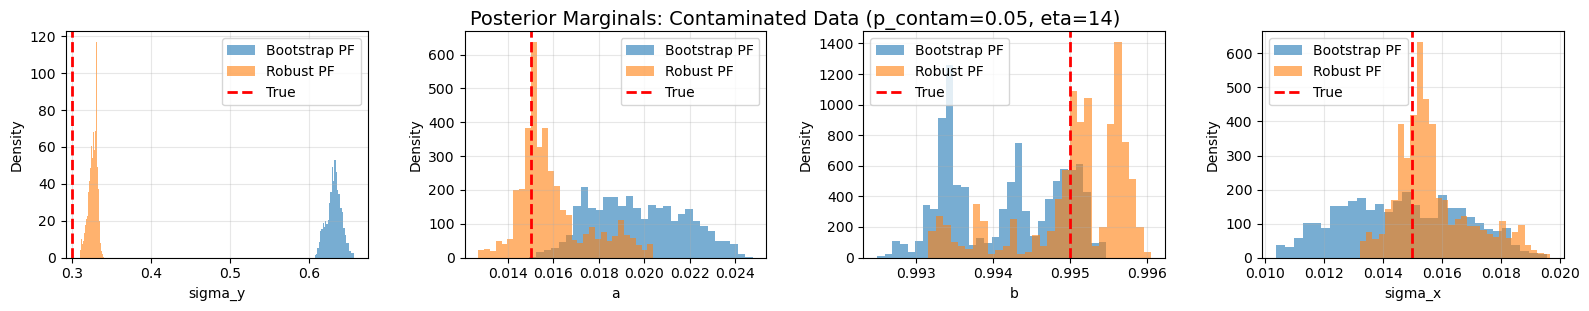

In [ ]:
# POSTERIOR MARGINAL HISTOGRAMS (CONTAMINATED DATA) 
fig = plot_posterior_marginals(chains_dict_contam, theta_true, param_names)
plt.suptitle('Posterior Marginals: Contaminated Data (p_contam=0.05, eta=14)', fontsize=14, y=1.02)
plt.show()


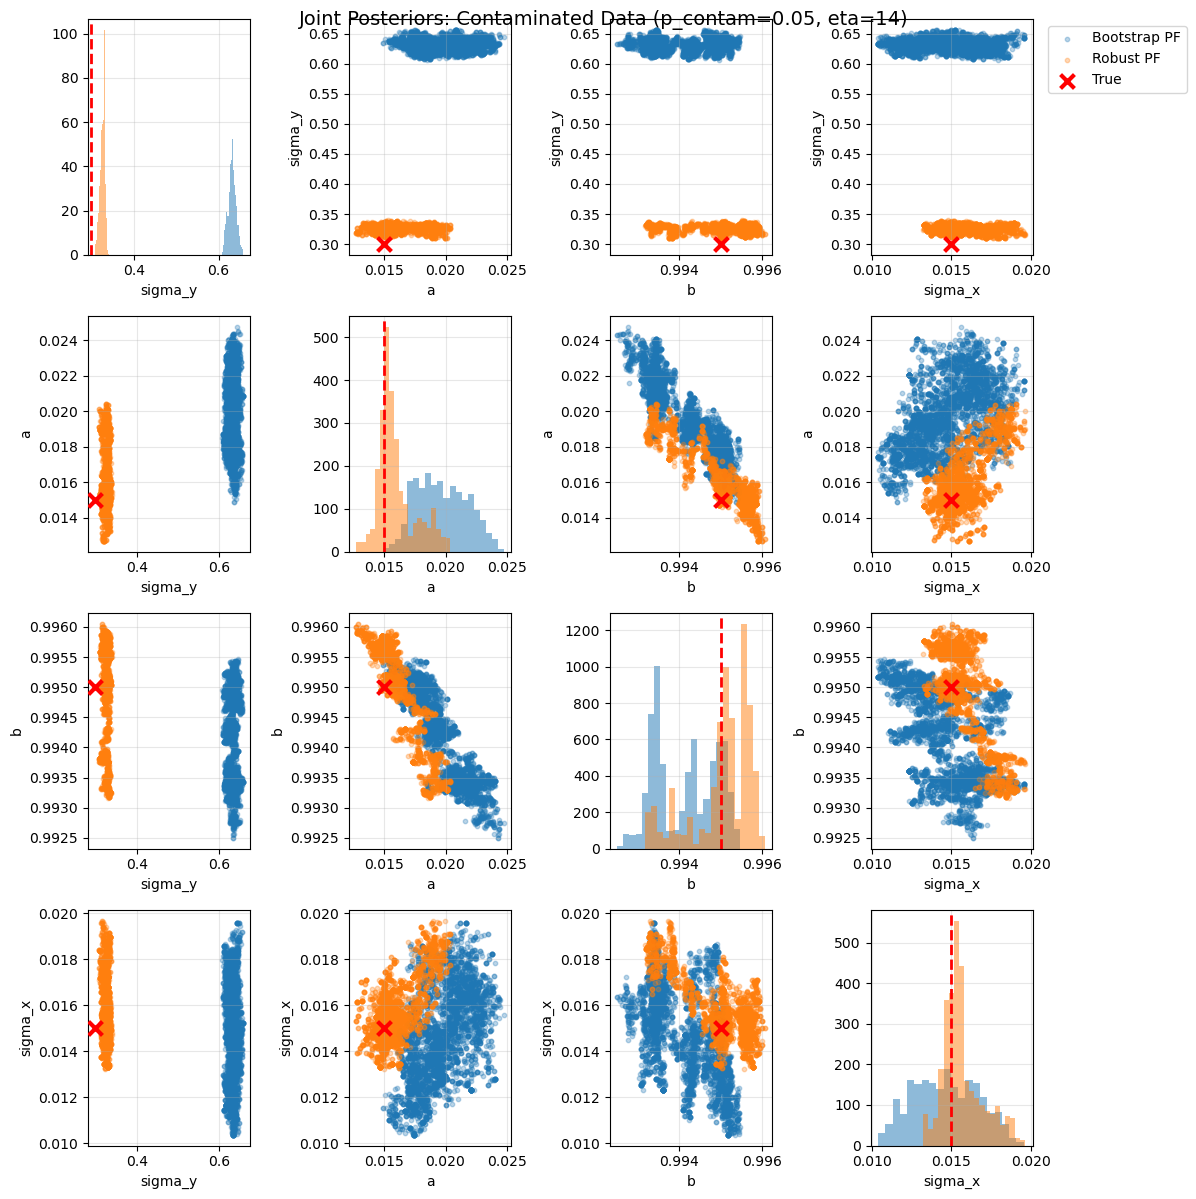

In [ ]:
# JOINT POSTERIOR SCATTER PLOTS (CONTAMINATED DATA) 
fig = plot_joint_posteriors(chains_dict_contam, theta_true, param_names)
plt.suptitle('Joint Posteriors: Contaminated Data (p_contam=0.05, eta=14)', fontsize=14, y=0.995)
plt.show()


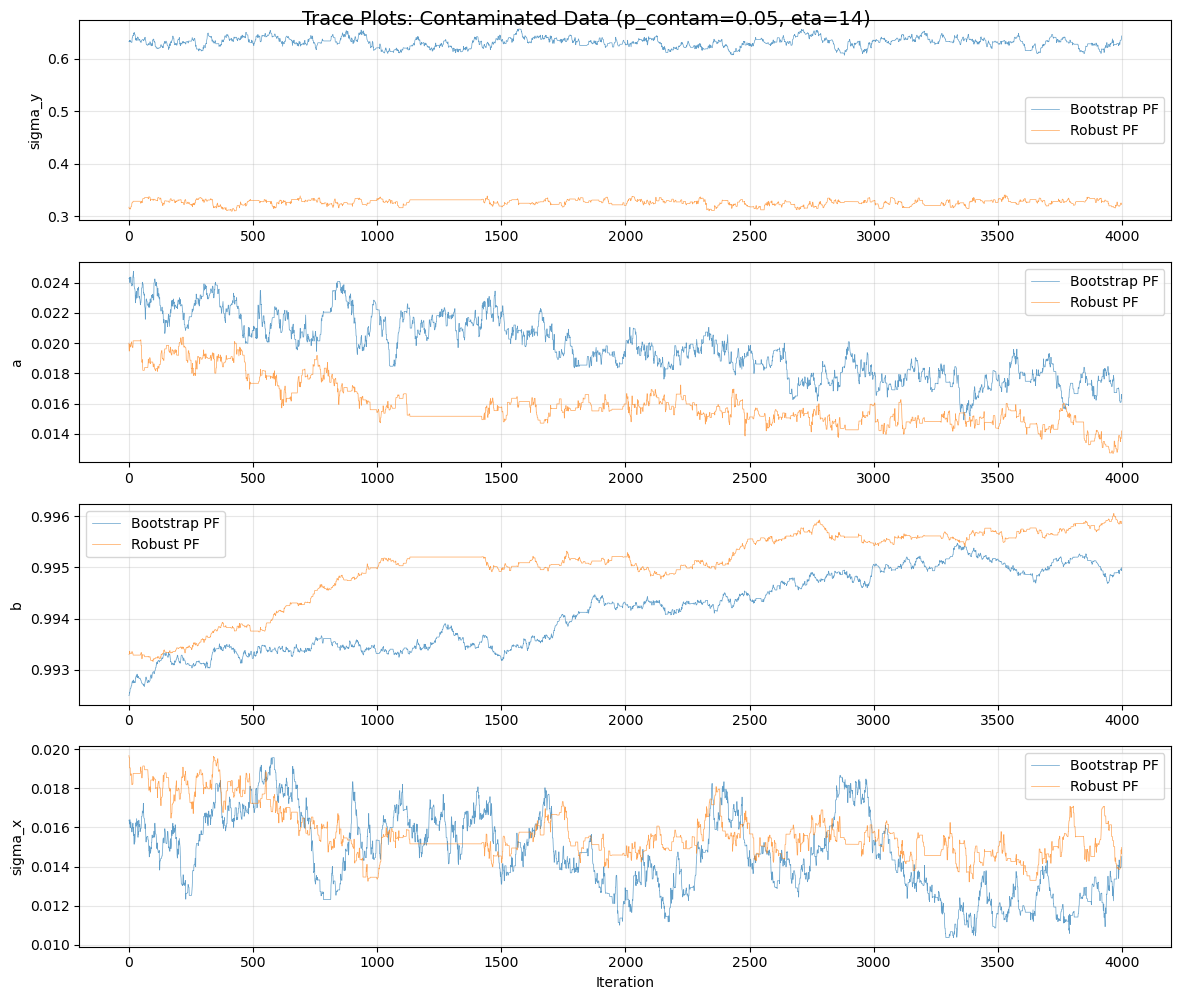

In [ ]:
# TRACE PLOTS (CONTAMINATED DATA) 
fig = plot_traces(chains_dict_contam, param_names)
plt.suptitle('Trace Plots: Contaminated Data (p_contam=0.05, eta=14)', fontsize=14, y=0.995)
plt.show()


When the simulated data are contaminated with artificial outliers, the behavior changes markedly. The bootstrap particle filter becomes strongly influenced by these extreme observations and reacts by inflating the observation noise and adjusting the other parameters to compensate, which leads to biased and dispersed posteriors. In contrast, the robust particle filter downweights the contaminated points, remains concentrated around the true parameter values, and provides stable inference despite the presence of outliers.

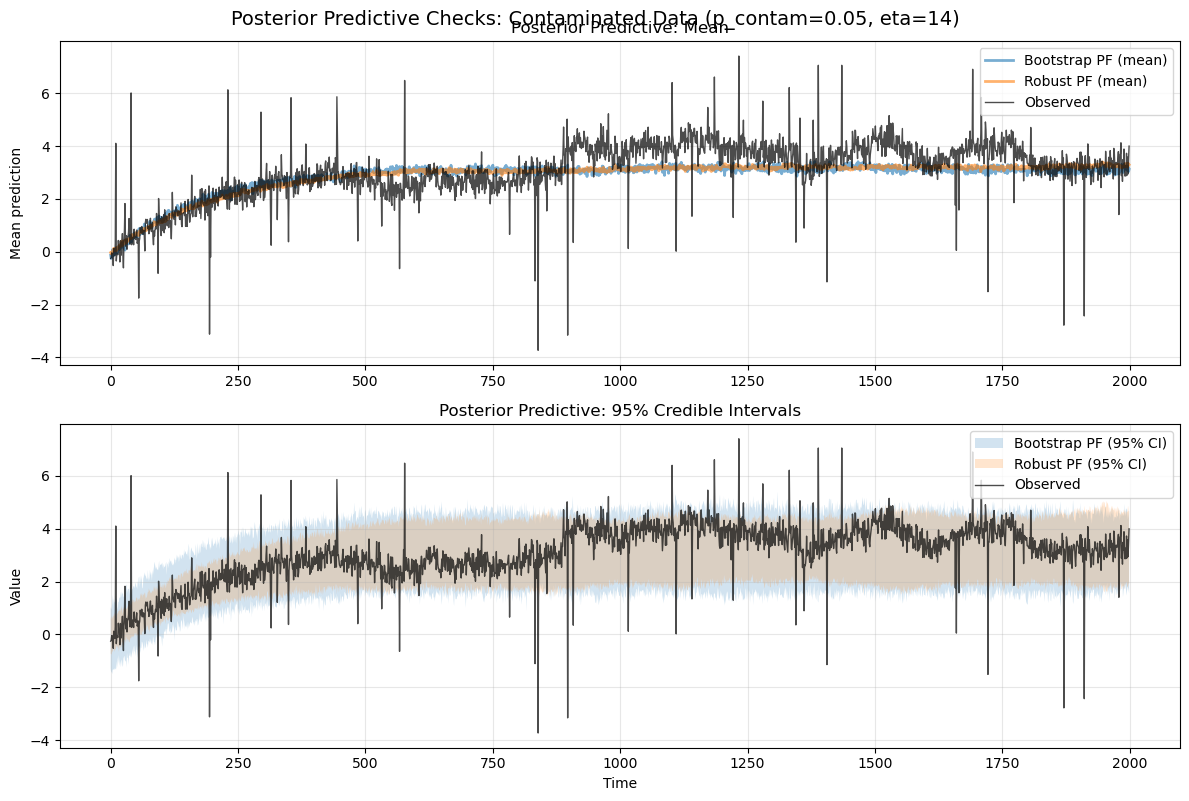

In [ ]:
# POSTERIOR PREDICTIVE CHECKS (CONTAMINATED DATA)
fig = plot_posterior_predictive(y_sim_contam, chains_dict_contam, param_names, n_samples=50)
plt.suptitle('Posterior Predictive Checks: Contaminated Data (p_contam=0.05, eta=14)', fontsize=14, y=0.995)
plt.show()


The black curve shows the observed data, which contains large artificial spikes due to contamination. The blue curve (bootstrap particle filter) is slightly pulled toward these extreme values: its mean prediction is slightly distorted because the Gaussian likelihood tries to explain the outliers. In contrast, the orange curve (robust particle filter) follows the smooth underlying trend of the data and largely ignores the spikes. This shows that the robust filter estimates the typical behavior of the process rather than reacting to rare extreme observations.

For the bootstrap filter, the credible intervals are inflated to accommodate the extreme spikes, leading to wider bands. The robust filter produces intervals that remain more stable and centered around the main trajectory of the data.

In [41]:
# COMPARISON: POSTERIOR STATISTICS (CONTAMINATED DATA)
print("Posterior Statistics Comparison - CONTAMINATED DATA")

for i, name in enumerate(param_names):
    print(f"\n{name} (True: {theta_true[i]:.4f}):")
    print(f"  Bootstrap PF: Mean={chain_bootstrap_contam[:, i].mean():.4f}, "
          f"Std={chain_bootstrap_contam[:, i].std():.4f}, "
          f"95% CI=[{np.percentile(chain_bootstrap_contam[:, i], 2.5):.4f}, "
          f"{np.percentile(chain_bootstrap_contam[:, i], 97.5):.4f}]")
    print(f"  Robust PF:    Mean={chain_robust_contam[:, i].mean():.4f}, "
          f"Std={chain_robust_contam[:, i].std():.4f}, "
          f"95% CI=[{np.percentile(chain_robust_contam[:, i], 2.5):.4f}, "
          f"{np.percentile(chain_robust_contam[:, i], 97.5):.4f}]")



Posterior Statistics Comparison - CONTAMINATED DATA

sigma_y (True: 0.3000):
  Bootstrap PF: Mean=0.6316, Std=0.0093, 95% CI=[0.6135, 0.6495]
  Robust PF:    Mean=0.3262, Std=0.0055, 95% CI=[0.3136, 0.3351]

a (True: 0.0150):
  Bootstrap PF: Mean=0.0197, Std=0.0020, 95% CI=[0.0163, 0.0236]
  Robust PF:    Mean=0.0159, Std=0.0015, 95% CI=[0.0136, 0.0196]

b (True: 0.9950):
  Bootstrap PF: Mean=0.9941, Std=0.0007, 95% CI=[0.9930, 0.9952]
  Robust PF:    Mean=0.9950, Std=0.0007, 95% CI=[0.9933, 0.9959]

sigma_x (True: 0.0150):
  Bootstrap PF: Mean=0.0146, Std=0.0020, 95% CI=[0.0111, 0.0183]
  Robust PF:    Mean=0.0157, Std=0.0013, 95% CI=[0.0135, 0.0188]


Key Insights (Contaminated Data):
- Bootstrap PF (Gaussian model) is sensitive to outliers and may be biased
- Robust PF uses robustified likelihood and should be more robust to contamination
- Compare how contamination affects posterior distributions and uncertainty
- Robust PF should maintain better inference quality in presence of outliers

## Real Data

In [53]:
data = pd.read_excel('FUTURE_NG1naturalgasRaw.xlsx')
volume = data['Volume'].values
volume = np.maximum(volume, 1e-10)  
y = np.log(volume)
data['Date'] = pd.to_datetime(data['Date'])
train_end = pd.to_datetime('2009-12-31')
train_mask = data['Date'] <= train_end
y_train = y[train_mask.values]

print(len(y))

5993


In [ ]:
# uniform priors on the parameters
def log_prior(theta):
    sigma_y, a, b, sigma_x = theta
    if not (0.01 < sigma_y < 2.0):
        return -np.inf
    if not (-0.1 < a < 0.1):
        return -np.inf
    if not (0.9 < b < 0.9999):
        return -np.inf
    if not (0.001 < sigma_x < 0.1):
        return -np.inf
    return 0.0
# proposal = random walk gaussian
# Sigma_prop = np.diag([
#     0.01**2,     # sigma_y
#     0.001**2,    # a
#     0.0001**2,   # b
#     0.001**2     # sigma_x
# ])
#reduce varuance
Sigma_prop = np.diag([
    0.003**2,     # sigma_y
    0.0003**2,    # a
    0.00003**2,   # b
    0.0003**2     # sigma_x
])
def propose(theta, Sigma):
    return np.random.multivariate_normal(theta, Sigma)
# PMMH kernel
def PMMH(
    y,
    theta_init,
    N_particles=1000,
    n_iter=20000,
    burn_in=5000,
    Sigma_prop=Sigma_prop,
    c=5.14
):
    theta_curr = np.array(theta_init)
    
    # Initial likelihood
    _, loglik_curr, _ = robust_pf_particles(
        y, theta_curr, N=N_particles, c=c
    )
    logpost_curr = loglik_curr + log_prior(theta_curr)

    chain = np.zeros((n_iter, len(theta_curr)))
    accept = 0

    for m in range(n_iter):
        if (m + 1) % 50 == 0:
            print(f"PMMH iteration {m+1}/{n_iter} (acceptance: {accept/(m+1):.2%})")
        
        theta_prop = propose(theta_curr, Sigma_prop)

        # Reject immediately if prior invalid
        lp_prop = log_prior(theta_prop)
        if lp_prop == -np.inf:
            chain[m] = theta_curr
            continue

        # Run RobPF for proposed theta
        _, loglik_prop, _ = robust_pf_particles(
            y, theta_prop, N=N_particles, c=c
        )

        logpost_prop = loglik_prop + lp_prop

        log_alpha = logpost_prop - logpost_curr

        if np.log(np.random.rand()) < log_alpha:
            theta_curr = theta_prop
            loglik_curr = loglik_prop
            logpost_curr = logpost_prop
            accept += 1

        chain[m] = theta_curr

    acc_rate = accept / n_iter
    return chain[burn_in:], acc_rate
theta_init = [0.4, 0.01, 0.99, 0.02]

chain, acc_rate = PMMH(
    y_train,
    theta_init,
    N_particles=1000,
    n_iter=5000, 
    burn_in=1000 
)

print("Acceptance rate:", acc_rate)
print("Posterior mean:", chain.mean(axis=0))

#1537 minutes

PMMH iteration 50/5000 (acceptance: 22.00%)
PMMH iteration 100/5000 (acceptance: 17.00%)
PMMH iteration 150/5000 (acceptance: 12.67%)
PMMH iteration 200/5000 (acceptance: 14.00%)
PMMH iteration 250/5000 (acceptance: 12.40%)
PMMH iteration 300/5000 (acceptance: 12.00%)
PMMH iteration 350/5000 (acceptance: 13.71%)
PMMH iteration 400/5000 (acceptance: 14.75%)
PMMH iteration 450/5000 (acceptance: 14.00%)
PMMH iteration 500/5000 (acceptance: 15.00%)
PMMH iteration 550/5000 (acceptance: 14.36%)
PMMH iteration 600/5000 (acceptance: 13.17%)
PMMH iteration 650/5000 (acceptance: 12.15%)
PMMH iteration 700/5000 (acceptance: 11.29%)
PMMH iteration 750/5000 (acceptance: 10.53%)
PMMH iteration 800/5000 (acceptance: 10.12%)
PMMH iteration 850/5000 (acceptance: 9.53%)
PMMH iteration 900/5000 (acceptance: 9.00%)
PMMH iteration 950/5000 (acceptance: 8.63%)
PMMH iteration 1000/5000 (acceptance: 8.20%)
PMMH iteration 1050/5000 (acceptance: 7.81%)
PMMH iteration 1100/5000 (acceptance: 7.45%)
PMMH iteration

Running Bootstrap PMMH...
Bootstrap PMMH: 200/5000 (acc: 43.00%)
Bootstrap PMMH: 400/5000 (acc: 42.50%)
Bootstrap PMMH: 600/5000 (acc: 39.50%)
Bootstrap PMMH: 800/5000 (acc: 32.25%)
Bootstrap PMMH: 1000/5000 (acc: 30.30%)
Bootstrap PMMH: 1200/5000 (acc: 27.83%)
Bootstrap PMMH: 1400/5000 (acc: 26.36%)
Bootstrap PMMH: 1600/5000 (acc: 24.06%)
Bootstrap PMMH: 1800/5000 (acc: 21.39%)
Bootstrap PMMH: 2000/5000 (acc: 20.65%)
Bootstrap PMMH: 2200/5000 (acc: 19.45%)
Bootstrap PMMH: 2400/5000 (acc: 17.88%)
Bootstrap PMMH: 2600/5000 (acc: 16.96%)
Bootstrap PMMH: 2800/5000 (acc: 16.21%)
Bootstrap PMMH: 3000/5000 (acc: 15.97%)
Bootstrap PMMH: 3200/5000 (acc: 15.59%)
Bootstrap PMMH: 3400/5000 (acc: 14.85%)
Bootstrap PMMH: 3600/5000 (acc: 14.64%)
Bootstrap PMMH: 3800/5000 (acc: 14.89%)
Bootstrap PMMH: 4000/5000 (acc: 14.27%)
Bootstrap PMMH: 4200/5000 (acc: 13.62%)
Bootstrap PMMH: 4400/5000 (acc: 13.30%)
Bootstrap PMMH: 4600/5000 (acc: 13.46%)
Bootstrap PMMH: 4800/5000 (acc: 13.65%)
Bootstrap PMMH: 50

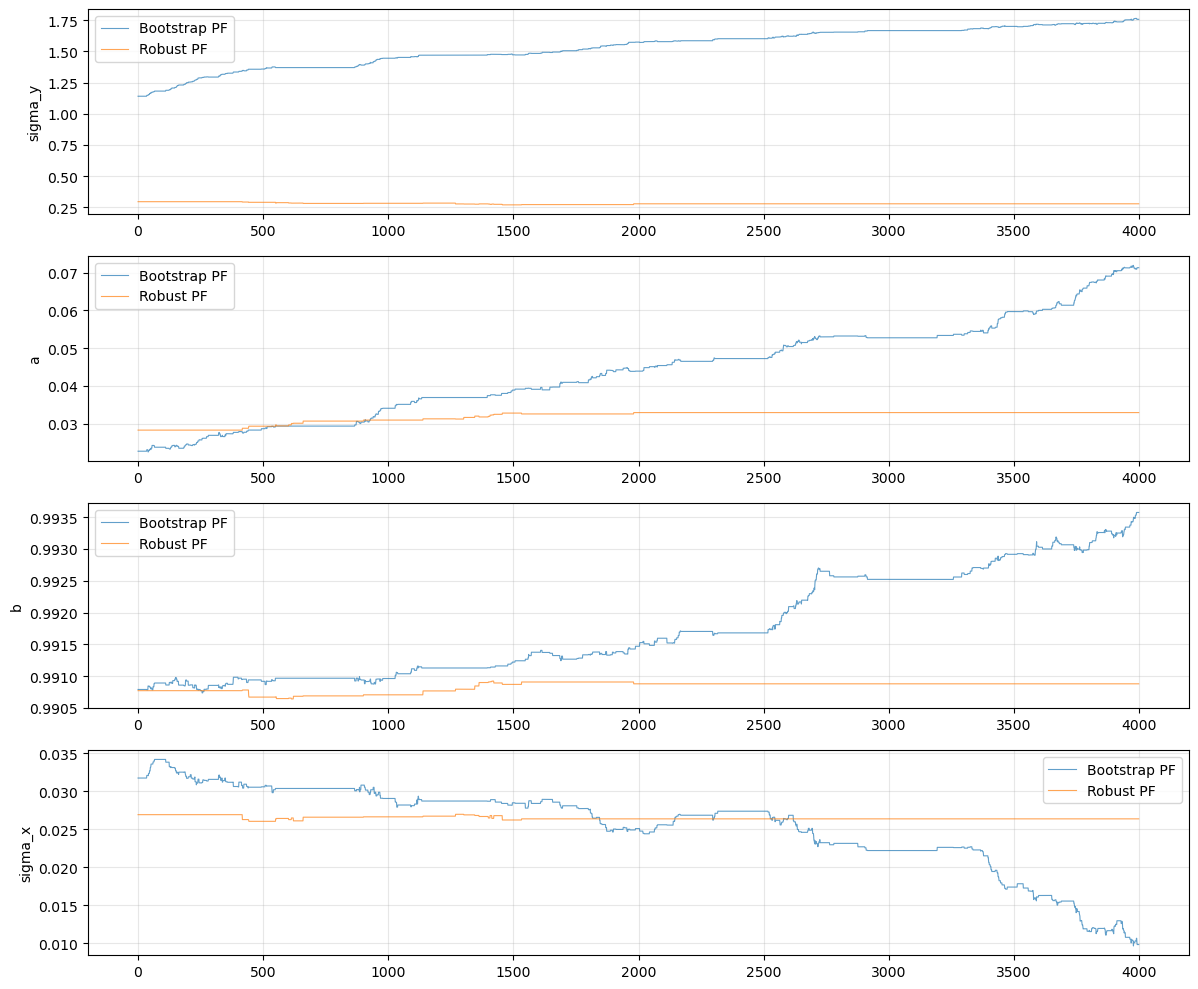


Bootstrap PF variance: [2.23895958e-02 1.54086574e-04 6.40287488e-07 3.02791078e-05]
Robust PF variance: [4.09128159e-05 2.49633689e-06 6.15463286e-09 4.57938607e-08]


In [ ]:
if 'PMMH_bootstrap' not in globals():
    def PMMH_bootstrap(y, theta_init, N_particles=1000, n_iter=5000, burn_in=1000, Sigma_prop=Sigma_prop):
        """PMMH using bootstrap (Gaussian) particle filter."""
        theta_curr = np.array(theta_init)
        _, loglik_curr, _ = bootstrap_pf_particles(y, theta_curr, N=N_particles)
        logpost_curr = loglik_curr + log_prior(theta_curr)
        
        chain = np.zeros((n_iter, len(theta_curr)))
        accept = 0
        
        for m in range(n_iter):
            if (m + 1) % 200 == 0:
                print(f"Bootstrap PMMH: {m+1}/{n_iter} (acc: {accept/(m+1):.2%})")
            
            theta_prop = propose(theta_curr, Sigma_prop)
            lp_prop = log_prior(theta_prop)
            if lp_prop == -np.inf:
                chain[m] = theta_curr
                continue
            
            _, loglik_prop, _ = bootstrap_pf_particles(y, theta_prop, N=N_particles)
            logpost_prop = loglik_prop + lp_prop
            
            if np.log(np.random.rand()) < logpost_prop - logpost_curr:
                theta_curr = theta_prop
                loglik_curr = loglik_prop
                logpost_curr = logpost_prop
                accept += 1
            
            chain[m] = theta_curr
        
        return chain[burn_in:], accept / n_iter

print("Running Bootstrap PMMH...")
chain_bootstrap, acc_bootstrap = PMMH_bootstrap(
    y_train,
    theta_init,
    N_particles=1000,
    n_iter=5000, 
    burn_in=1000
)
print(f"Bootstrap PF acceptance rate: {acc_bootstrap:.2%}")

# chain is from Robust PMMH (already run above)
chain_robust = chain

# Plot both chains for comparison
names = ["sigma_y", "a", "b", "sigma_x"]
fig, axes = plt.subplots(4, 1, figsize=(12, 10))
for i in range(4):
    axes[i].plot(chain_bootstrap[:, i], alpha=0.7, label='Bootstrap PF', linewidth=0.8)
    axes[i].plot(chain_robust[:, i], alpha=0.7, label='Robust PF', linewidth=0.8)
    axes[i].set_ylabel(names[i])
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nBootstrap PF variance:", np.var(chain_bootstrap, axis=0))
print("Robust PF variance:", np.var(chain_robust, axis=0))

In [55]:
# POSTERIOR MARGINAL HISTOGRAMS (CONTAMINATED DATA) 
# Store chains
chains_dict_true = {
    'Bootstrap PF': chain_bootstrap,
    'Robust PF': chain_robust
}

print("Results Summary (Real Data)")
print(f"Bootstrap PF acceptance rate: {acc_bootstrap:.2%}")
print(f"Robust PF acceptance rate: {acc_robust:.2%}")
print(f"\nBootstrap PF posterior means: {chain_bootstrap.mean(axis=0)}")
print(f"Robust PF posterior means: {chain_robust.mean(axis=0)}")


Results Summary (Real Data)
Bootstrap PF acceptance rate: 14.28%
Robust PF acceptance rate: 46.76%

Bootstrap PF posterior means: [1.53197206 0.04382025 0.9917492  0.02547458]
Robust PF posterior means: [0.27989832 0.03182216 0.99083182 0.02644145]


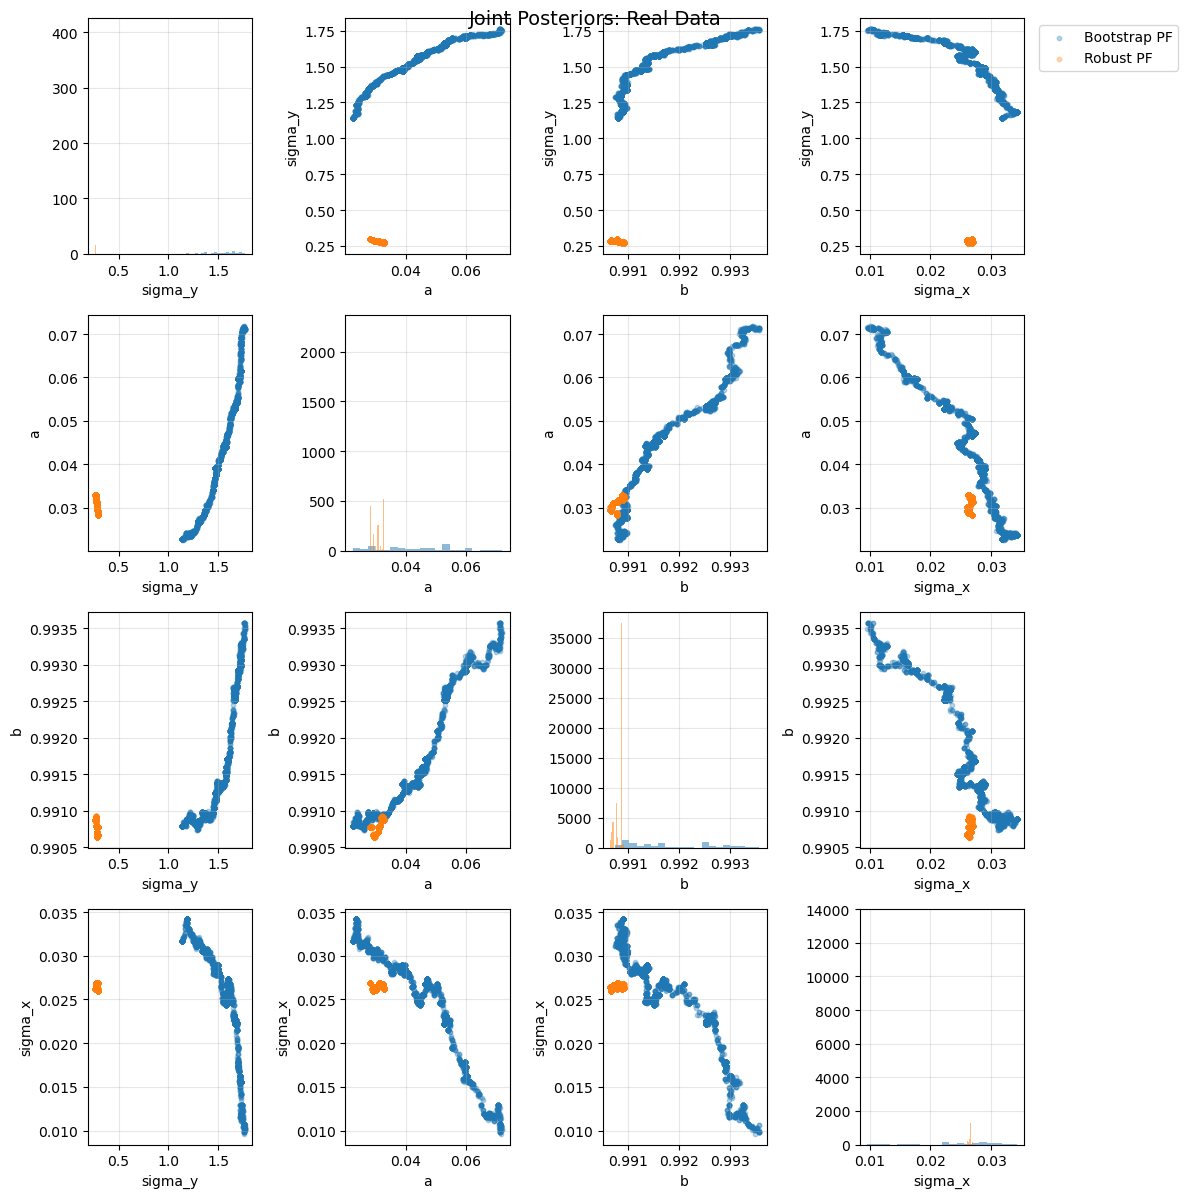

In [48]:
fig = plot_joint_posteriors(chains_dict_true, theta_true=None, param_names=param_names)
plt.suptitle('Joint Posteriors: Real Data', fontsize=14, y=0.995)
plt.show()


On real data, the Gaussian likelihood induces strong posterior degeneracies due to outliers, while the robust filter restores identifiability and yields a sharply concentrated posterior.

On real data, the bootstrap particle filter leads to a highly dispersed posterior, with strong correlations between parameters such as the observation noise, persistence, and state noise. This indicates that the Gaussian likelihood tries to accommodate extreme observations by increasing noise and adjusting parameters in unrealistic ways. As a result, the parameter estimates become unstable and highly dependent on each other. 

In contrast, the robust particle filter yields a much more concentrated posterior, with weaker parameter correlations, because it downweights outliers and focuses inference on the typical dynamics of the data rather than extreme events, leading to more stable and well-defined parameter estimates that better reflect the typical behavior of the data.
